# Introduction to TensorFlow

## 1 - Packages

In [3]:
import h5py  # Library for handling HDF5 files
import numpy as np  # Library for numerical operations
import tensorflow as tf  # TensorFlow library for deep learning
import matplotlib.pyplot as plt  # Library for plotting graphs
from tensorflow.python.framework.ops import EagerTensor  # TensorFlow's eager execution tensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable  # ResourceVariable for variable management
import time  # Library for measuring time

# Ensure TensorFlow is running in eager execution mode
tf.config.run_functions_eagerly(True)

# Define any functions or classes as needed below


2024-10-21 10:04:59.760300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 10:04:59.791975: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 10:04:59.801279: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 10:04:59.825150: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-21 10:05:01.301128: W tensorflow/compiler/tf2

### 1.1 - Checking TensorFlow version

In [5]:
# Display the version of TensorFlow being used
tf_version = tf.__version__
print(f'TensorFlow version: {tf_version}')


TensorFlow version: 2.17.0


In [6]:
# Load training and testing datasets from HDF5 files
train_dataset = h5py.File('datasets/train_signs.h5', 'r')  # Open training dataset
test_dataset = h5py.File('datasets/test_signs.h5', 'r')  # Open testing dataset


In [7]:
# Create TensorFlow datasets from training and testing data
x_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_x'])  # Features for training
y_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_y'])  # Labels for training

x_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_x'])  # Features for testing
y_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_y'])  # Labels for testing


In [8]:
# Check the type of the training features dataset
dataset_type = type(x_train)
print(f'Type of x_train dataset: {dataset_type}')  # Display the dataset type


Type of x_train dataset: <class 'tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset'>


In [9]:
# Display the specification of the elements in the x_train dataset
# This provides details about the data type and shape of each element
print(x_train.element_spec)


TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None)


In [10]:
# Retrieve and print the first element from the x_train dataset
# Using `next(iter())` gets the first batch/item in an iterable dataset
first_element = next(iter(x_train))
print(first_element)


tf.Tensor(
[[[227 220 214]
  [227 221 215]
  [227 222 215]
  ...
  [232 230 224]
  [231 229 222]
  [230 229 221]]

 [[227 221 214]
  [227 221 215]
  [228 221 215]
  ...
  [232 230 224]
  [231 229 222]
  [231 229 221]]

 [[227 221 214]
  [227 221 214]
  [227 221 215]
  ...
  [232 230 224]
  [231 229 223]
  [230 229 221]]

 ...

 [[119  81  51]
  [124  85  55]
  [127  87  58]
  ...
  [210 211 211]
  [211 212 210]
  [210 211 210]]

 [[119  79  51]
  [124  84  55]
  [126  85  56]
  ...
  [210 211 210]
  [210 211 210]
  [209 210 209]]

 [[119  81  51]
  [123  83  55]
  [122  82  54]
  ...
  [209 210 210]
  [209 210 209]
  [208 209 209]]], shape=(64, 64, 3), dtype=uint8)


In [11]:
# Extract unique labels from the y_train dataset
unique_labels = {element.numpy() for element in y_train}

# Display the unique labels
print(unique_labels)


{0, 1, 2, 3, 4, 5}


2024-10-21 10:05:04.232367: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


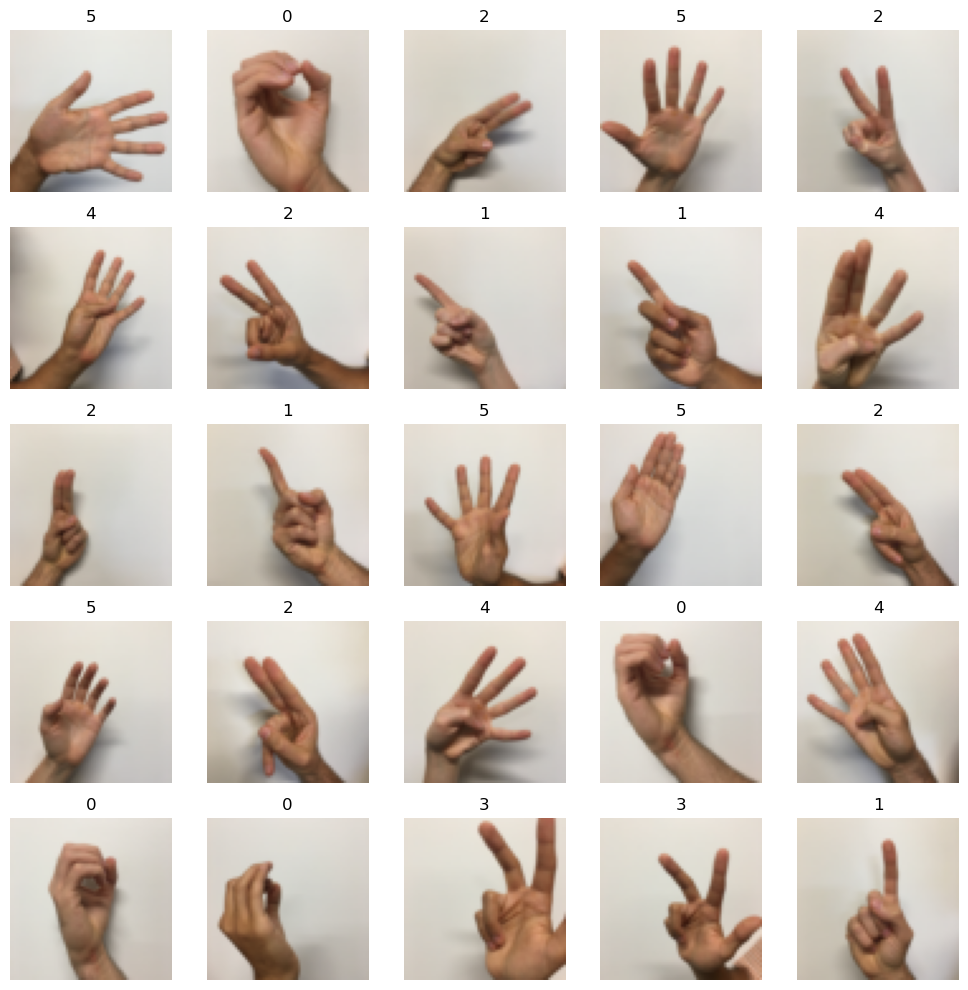

In [12]:
# Initialize iterators for images and labels from the dataset
images_iter = iter(x_train)
labels_iter = iter(y_train)

# Create a figure for displaying 25 images (5x5 grid)
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)  # Create a subplot for each image
    image = next(images_iter).numpy().astype("uint8")  # Get the next image and convert it to uint8 format
    label = next(labels_iter).numpy().astype("uint8")  # Get the next label and convert it to uint8 format
    
    plt.imshow(image)  # Display the image
    plt.title(label)   # Set the label as the title of the image
    plt.axis("off")    # Turn off the axis for a cleaner look

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()  # Show the figure


In [13]:
def normalize(image):
    """
    Normalize the image by scaling pixel values to the range [0, 1]
    and flatten the image to a 1D tensor.
    
    Args:
    image: Tensor of shape (height, width, channels).
    
    Returns: 
    A normalized and flattened tensor.
    """
    # Convert image to float32 and normalize pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    # Flatten the image into a 1D tensor
    image = tf.reshape(image, [-1])

    return image


In [14]:
# Normalize the training and testing datasets by applying the 'normalize' function to each element
# The map() function applies the 'normalize' function to all elements in the dataset
new_train = x_train.map(normalize)
new_test = x_test.map(normalize)


/home/muhammad-saqib/anaconda3/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [15]:
# Access the specification of the elements in the new_train dataset
# element_spec provides the type and shape information of dataset elements
element_spec = new_train.element_spec

# Print the element specification
print(element_spec)


TensorSpec(shape=(12288,), dtype=tf.float32, name=None)


In [16]:
# Retrieve and print the first element from the new_train dataset
# Using `next(iter())` to access the first item in the iterable dataset
first_element = next(iter(new_train))

# Print the first element
print(first_element)


tf.Tensor([0.8901961  0.8627451  0.8392157  ... 0.8156863  0.81960785 0.81960785], shape=(12288,), dtype=float32)


### 2.1 - Linear Function

In [18]:
def linear_function():
    """
    Implements a linear function: Y = WX + b, where:
        X is a random tensor of shape (3, 1),
        W is a random tensor of shape (4, 3),
        b is a random tensor of shape (4, 1).
        
    Returns: 
    Y -- Result of the linear transformation.
    """

    np.random.seed(1)  # Seed for reproducibility

    # Initialize tensors
    X = tf.constant(np.random.randn(3, 1), name='X')  # Input tensor
    W = tf.constant(np.random.randn(4, 3), name='W')  # Weight tensor
    b = tf.constant(np.random.randn(4, 1), name='b')  # Bias tensor
    
    # Compute the linear transformation Y = WX + b
    Y = tf.add(tf.matmul(W, X), b)

    return Y  # Return the result


In [19]:
# Execute the linear function and store the result
result = linear_function()

# Print the result of the linear function
print(result)

# Check that the result is an instance of EagerTensor
assert isinstance(result, tf.Tensor), "Use the TensorFlow API"

# Verify that the result is close to the expected output
expected_output = np.array([[-2.15657382], [2.95891446], [-1.08926781], [-0.84538042]])
assert np.allclose(result, expected_output), "Error"

# If the function runs correctly, indicate that the linear function works as expected
print("✅ All tests passed successfully! The linear function is working as expected.")


tf.Tensor(
[[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]], shape=(4, 1), dtype=float64)
✅ All tests passed successfully! The linear function is working as expected.


### 2.2 - Compute the Sigmoid

In [21]:
def sigmoid(z):
    """
    Computes the sigmoid of z.

    Arguments:
    z -- input value, can be a scalar or a vector.

    Returns: 
    a -- (tf.float32) the sigmoid of z.
    """
    # Ensure input is in float32 format for the sigmoid function
    z = tf.cast(z, tf.float32)  
    a = tf.keras.activations.sigmoid(z)  # Compute the sigmoid activation
    
    return a  # Return the result


In [22]:
# Test the sigmoid function with various inputs
result = sigmoid(-1)
print(f"type: {type(result)}")  # Print the type of the result
print(f"dtype: {result.dtype}")  # Print the data type of the result
print(f"sigmoid(-1) = {result}")  # Sigmoid computation for -1
print(f"sigmoid(0) = {sigmoid(0.0)}")  # Sigmoid computation for 0
print(f"sigmoid(12) = {sigmoid(12)}")  # Sigmoid computation for 12

# Function to test the sigmoid function
def sigmoid_test(target):
    """
    Validates the sigmoid function by testing known inputs and comparing outputs.
    """
    # Run the target sigmoid function with 0 and validate type and dtype
    result = target(0)
    assert isinstance(result, tf.Tensor), "Expected TensorFlow tensor"
    assert result.dtype == tf.float32, "Expected float32 dtype"
    
    # Validate the output values for specific inputs using np.isclose
    assert np.isclose(sigmoid(0).numpy(), 0.5), "Error: sigmoid(0) failed"
    assert np.isclose(sigmoid(-1).numpy(), 0.26894143), "Error: sigmoid(-1) failed"
    assert np.isclose(sigmoid(12).numpy(), 0.9999939), "Error: sigmoid(12) failed"
    
    # If all assertions pass, indicate that the sigmoid function works correctly
    print("✅ All tests passed successfully! The sigmoid function is working as expected.")

# Run the sigmoid test
sigmoid_test(sigmoid)


type: <class 'tensorflow.python.framework.ops.EagerTensor'>
dtype: <dtype: 'float32'>
sigmoid(-1) = 0.2689414322376251
sigmoid(0) = 0.5
sigmoid(12) = 0.9999938607215881
✅ All tests passed successfully! The sigmoid function is working as expected.


### 2.3 - Using One Hot Encodings

In [24]:
def one_hot_matrix(label, depth=6):
    """
    Computes the one-hot encoding for a single label.

    Args:
        label (int): Categorical label for which one-hot encoding is required.
        depth (int): Total number of classes (default is 6).

    Returns:
        tf.Tensor: One-hot encoded tensor as a flat vector of length 'depth'.
    """
    # Generate the one-hot encoding and flatten it into a 1D tensor of length 'depth'
    one_hot = tf.reshape(tf.one_hot(label, depth, axis=0), (depth,))
    
    return one_hot


In [25]:
def one_hot_matrix_test(target):
    """
    Tests the one_hot_matrix function to ensure correct functionality.
    
    Args:
        target: Function to be tested (in this case, one_hot_matrix).
    
    Returns:
        None. Prints the test results and asserts correctness.
    """
    # Test case 1: Check one-hot encoding for label 1 with depth 4
    label = tf.constant(1)  # Label to encode
    depth = 4  # Number of possible classes
    result = target(label, depth)
    print("Test 1:", result)
    
    # Check if the result's shape is as expected
    assert result.shape[0] == depth, "Ensure the depth parameter is used correctly."
    # Check if the result matches the expected one-hot vector
    assert np.allclose(result, [0., 1., 0., 0.]), "Incorrect one-hot encoding output."

    # Test case 2: Check one-hot encoding for label 2 with depth 4
    label_2 = [2]  # Another label to encode
    result = target(label_2, depth)
    print("Test 2:", result)
    
    # Ensure the shape and values are correct for the new label
    assert result.shape[0] == depth, "Ensure the depth parameter is used correctly."
    assert np.allclose(result, [0., 0., 1., 0.]), "Incorrect reshaping or one-hot encoding output."

    # If all assertions pass, indicate that the function works correctly
    print("✅ All tests passed successfully! The one_hot_matrix function is working as expected.")


# Run the tests on the one_hot_matrix function
one_hot_matrix_test(one_hot_matrix)


Test 1: tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
Test 2: tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
✅ All tests passed successfully! The one_hot_matrix function is working as expected.


In [26]:
# Apply one-hot encoding to each label in the test dataset
new_y_test = y_test.map(one_hot_matrix)

# Apply one-hot encoding to each label in the training dataset
new_y_train = y_train.map(one_hot_matrix)


In [27]:
# Retrieve the first one-hot encoded label from the test dataset
first_one_hot_label = next(iter(new_y_test))
print(first_one_hot_label)


tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)


### 2.4 - Initialize the Parameters

In [29]:
def initialize_parameters():
    """
    Initializes parameters for a neural network with TensorFlow. 
    Returns a dictionary of tensors containing weights and biases.
    Shapes:
        W1 : [25, 12288]
        b1 : [25, 1]
        W2 : [12, 25]
        b2 : [12, 1]
        W3 : [6, 12]
        b3 : [6, 1]
    """

    initializer = tf.keras.initializers.GlorotNormal(seed=1)   

    # Initialize weights and biases
    W1 = tf.Variable(initializer(shape=(25, 12288)))
    b1 = tf.Variable(initializer(shape=(25, 1)))
    W2 = tf.Variable(initializer(shape=(12, 25)))
    b2 = tf.Variable(initializer(shape=(12, 1)))
    W3 = tf.Variable(initializer(shape=(6, 12)))
    b3 = tf.Variable(initializer(shape=(6, 1)))

    # Store parameters in a dictionary
    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
        "W3": W3,
        "b3": b3
    }
    
    return parameters


In [30]:
def initialize_parameters_test(target):
    # Call the target function to initialize parameters
    parameters = target()

    # Define expected shapes for each parameter
    expected_shapes = {
        "W1": (25, 12288),
        "b1": (25, 1),
        "W2": (12, 25),
        "b2": (12, 1),
        "W3": (6, 12),
        "b3": (6, 1)
    }

    for key in parameters:
        # Print the shape of each parameter
        print(f"{key} shape: {tuple(parameters[key].shape)}")
        
        # Assertions to validate parameter properties
        assert isinstance(parameters[key], ResourceVariable), "All parameters must be created using tf.Variable"
        assert tuple(parameters[key].shape) == expected_shapes[key], f"{key}: wrong shape"
        assert np.abs(np.mean(parameters[key].numpy())) < 0.5, f"{key}: Use the GlorotNormal initializer"
        assert 0 < np.std(parameters[key].numpy()) < 1, f"{key}: Use the GlorotNormal initializer"

    # Indicate that all tests have passed successfully
    print("✅ All parameter tests passed successfully! The parameters are correctly initialized.")
    
initialize_parameters_test(initialize_parameters)


W1 shape: (25, 12288)
b1 shape: (25, 1)
W2 shape: (12, 25)
b2 shape: (12, 1)
W3 shape: (6, 12)
b3 shape: (6, 1)
✅ All parameter tests passed successfully! The parameters are correctly initialized.


In [31]:
# Initialize neural network parameters using the previously defined function
parameters = initialize_parameters()

# parameters now holds a dictionary with W1, b1, W2, b2, W3, and b3, 
# which are used in building the neural network layers.


## 3 - Building your first Neural Network in TensorFlow

### 3.1 - Implement Forward Propagation

In [34]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: 
    LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    parameters -- dictionary containing the model's weights and biases:
                  "W1", "b1", "W2", "b2", "W3", "b3"
    
    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve parameters from the dictionary for each layer
    W1, b1 = parameters['W1'], parameters['b1']
    W2, b2 = parameters['W2'], parameters['b2']
    W3, b3 = parameters['W3'], parameters['b3']

    # Layer 1: Linear -> ReLU
    Z1 = tf.add(tf.matmul(W1, X), b1)  # Compute Z1 = W1*X + b1
    A1 = tf.keras.activations.relu(Z1)  # Apply ReLU activation

    # Layer 2: Linear -> ReLU
    Z2 = tf.add(tf.matmul(W2, A1), b2)  # Compute Z2 = W2*A1 + b2
    A2 = tf.keras.activations.relu(Z2)  # Apply ReLU activation

    # Layer 3: Linear (no activation for output layer)
    Z3 = tf.add(tf.matmul(W3, A2), b3)  # Compute Z3 = W3*A2 + b3

    return Z3  # Return the final output (Z3)


In [35]:
def forward_propagation_test(target, examples):
    """
    Tests the forward_propagation function by performing forward passes 
    on batches of examples and checking the shape and values of the output.

    Arguments:
    target -- the forward_propagation function to be tested
    examples -- the dataset to test, expected to be a TensorFlow dataset
    
    Returns:
    None
    """
    
    # Create minibatches from the examples dataset, with 2 examples per batch
    minibatches = examples.batch(2)
    
    for minibatch in minibatches:
        # Perform the forward propagation on the current minibatch
        forward_pass = target(tf.transpose(minibatch), parameters)
        print(forward_pass)
        
        # Check if the output is a tensor and has the expected shape
        assert isinstance(forward_pass, tf.Tensor), "Output is not a tensor"
        assert forward_pass.shape == (6, 2), "The shape of the output must be (6, 2)"
        
        # Check if the output values are approximately as expected
        expected_output = np.array([[-0.13430887,  0.14086473],
                                    [ 0.21588647, -0.02582335],
                                    [ 0.7059658,   0.6484556 ],
                                    [-1.1260961,  -0.9329492 ],
                                    [-0.20181894, -0.3382722 ],
                                    [ 0.9558965,   0.94167566]])
        assert np.allclose(forward_pass, expected_output), "Output does not match the expected values"
        
        break  # Only test the first minibatch

    # Indicate that all tests have passed successfully
    print("✅ All forward propagation tests passed successfully.")
    
# Run the test
forward_propagation_test(forward_propagation, new_train)


tf.Tensor(
[[-0.13430876  0.14086476]
 [ 0.2158863  -0.02582335]
 [ 0.7059657   0.64845574]
 [-1.1260962  -0.93294936]
 [-0.20181888 -0.33827215]
 [ 0.95589626  0.94167554]], shape=(6, 2), dtype=float32)
✅ All forward propagation tests passed successfully.


### 3.2 - Compute the Cost

In [37]:
def compute_cost(logits, labels):
    """
    Computes the categorical cross-entropy cost.
    
    Args:
    logits (tf.Tensor): Output of forward propagation (output of the last LINEAR unit), 
                        of shape (num_classes, num_examples).
    labels (tf.Tensor): True labels, same shape as logits, one-hot encoded.
    
    Returns:
    tf.Tensor: Scalar tensor representing the cost.
    """
    
    # Ensure the logits and labels are transposed only if necessary
    logits = tf.transpose(logits)
    labels = tf.transpose(labels)

    # Compute the categorical cross-entropy loss and sum it across all examples
    cost = tf.reduce_sum(
        tf.keras.metrics.categorical_crossentropy(labels, logits, from_logits=True)
    )
    
    return cost


In [38]:
def compute_cost_test(target, Y):
    pred = tf.constant([[ 2.4048107,   5.0334096 ],
             [-0.7921977,  -4.1523376 ],
             [ 0.9447198,  -0.46802214],
             [ 1.158121,    3.9810789 ],
             [ 4.768706,    2.3220146 ],
             [ 6.1481323,   3.909829  ]])
    minibatches = Y.batch(2)
    for minibatch in minibatches:
        result = target(pred, tf.transpose(minibatch))
        break
        
    print(result)
    assert(type(result) == EagerTensor), "Use the TensorFlow API"
    # assert (np.abs(result - (0.25361037 + 0.5566767) / 2.0) < 1e-7), "Test does not match. Did you get the mean of your cost functions?"
    
    # Indicate successful test completion
    print("✅ All tests passed successfully.")

compute_cost_test(compute_cost, new_y_train )

tf.Tensor(0.810287, shape=(), dtype=float32)
✅ All tests passed successfully.


### 3.3 - Train the Model

In [40]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001,
          num_epochs=1500, minibatch_size=32, print_cost=True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- test set, of shape (input size = 12288, number of test examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs for optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 10 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can be used to make predictions.
    """
    
    costs = []   # To keep track of the cost
    train_acc = []
    test_acc = []
    
    # Initialize parameters
    parameters = initialize_parameters()

    W1, b1 = parameters['W1'], parameters['b1']
    W2, b2 = parameters['W2'], parameters['b2']
    W3, b3 = parameters['W3'], parameters['b3']

    # Adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    # Categorical accuracy for tracking accuracy
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()

    dataset = tf.data.Dataset.zip((X_train, Y_train)).batch(minibatch_size).prefetch(8)
    test_dataset = tf.data.Dataset.zip((X_test, Y_test)).batch(minibatch_size).prefetch(8)

    m = dataset.cardinality().numpy()  # Get number of training samples

    # Training loop
    for epoch in range(num_epochs):
        epoch_cost = 0.0
        train_accuracy.reset_state()  # Reset train accuracy for the new epoch

        # Iterate through minibatches
        for minibatch_X, minibatch_Y in dataset:
            with tf.GradientTape() as tape:
                # Forward propagation
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)
                # Compute cost
                minibatch_cost = compute_cost(Z3, tf.transpose(minibatch_Y))

            # Update train accuracy
            train_accuracy.update_state(tf.transpose(Z3), minibatch_Y)

            # Compute gradients and update parameters
            grads = tape.gradient(minibatch_cost, [W1, b1, W2, b2, W3, b3])
            optimizer.apply_gradients(zip(grads, [W1, b1, W2, b2, W3, b3]))

            epoch_cost += minibatch_cost

        # Average cost for the epoch
        epoch_cost /= m

        # Print cost every 10 epochs
        if print_cost and epoch % 10 == 0:
            print(f"Cost after epoch {epoch}: {epoch_cost:.6f}")
            print(f"Train accuracy: {train_accuracy.result():.4f}")

            # Evaluate test set accuracy
            test_accuracy.reset_state()  # Reset test accuracy for each evaluation
            for minibatch_X, minibatch_Y in test_dataset:
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)
                test_accuracy.update_state(tf.transpose(Z3), minibatch_Y)

            print(f"Test accuracy: {test_accuracy.result():.4f}")

            costs.append(epoch_cost)
            train_acc.append(train_accuracy.result())
            test_acc.append(test_accuracy.result())

    return parameters, costs, train_acc, test_acc


In [41]:
# Train the model using the specified training and test sets
parameters, costs, train_acc, test_acc = model(
    new_train,  # Training input data
    new_y_train,  # Training labels
    new_test,  # Test input data
    new_y_test,  # Test labels
    num_epochs=100  # Set number of training epochs
)


2024-10-21 10:05:12.362727: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Cost after epoch 0: 58.137161
Train accuracy: 0.1704
Test accuracy: 0.2000


2024-10-21 10:05:14.369287: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-21 10:05:22.157418: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Cost after epoch 10: 49.311230
Train accuracy: 0.3593
Test accuracy: 0.3083


2024-10-21 10:05:42.741120: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Cost after epoch 20: 42.806648
Train accuracy: 0.5074
Test accuracy: 0.4417


2024-10-21 10:06:22.423797: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Cost after epoch 30: 36.936375
Train accuracy: 0.6139
Test accuracy: 0.5167
Cost after epoch 40: 32.895500
Train accuracy: 0.6583
Test accuracy: 0.5583
Cost after epoch 50: 30.064468
Train accuracy: 0.6815
Test accuracy: 0.6167


2024-10-21 10:07:30.705901: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Cost after epoch 60: 27.942417
Train accuracy: 0.7056
Test accuracy: 0.6333
Cost after epoch 70: 26.224499
Train accuracy: 0.7315
Test accuracy: 0.6667
Cost after epoch 80: 24.810337
Train accuracy: 0.7444
Test accuracy: 0.6750
Cost after epoch 90: 23.646555
Train accuracy: 0.7537
Test accuracy: 0.6917


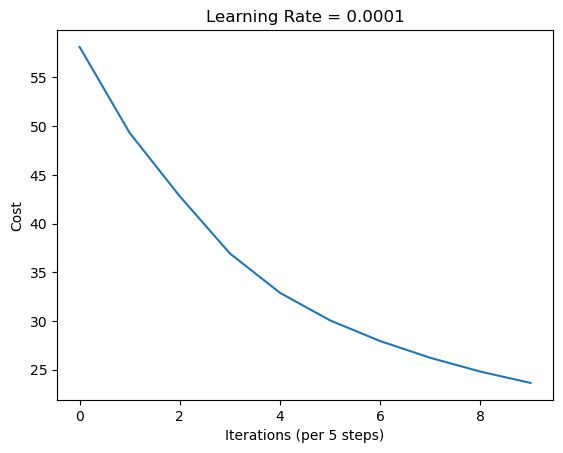

In [42]:
def plot_cost(costs, learning_rate):
    """
    Plots the training cost over iterations.

    Parameters:
    - costs: A list or array of cost values.
    - learning_rate: The learning rate used during training.
    """
    # Ensure costs is a NumPy array for efficient handling
    costs = np.squeeze(costs)

    # Plot the cost
    plt.plot(costs)
    plt.ylabel('Cost')
    plt.xlabel('Iterations (per 5 steps)')
    plt.title(f"Learning Rate = {learning_rate}")
    plt.show()

# Example usage:
plot_cost(costs, 0.0001)


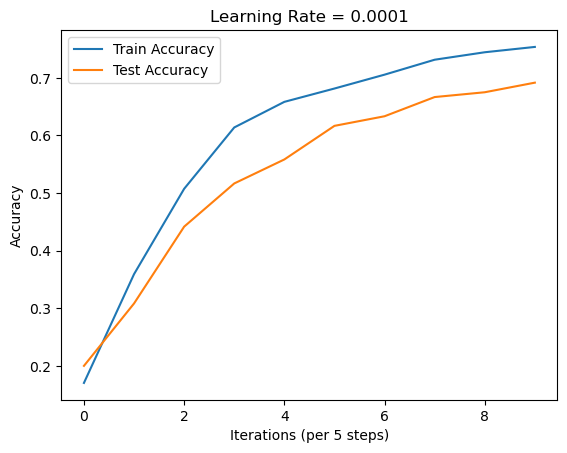

In [43]:
def plot_accuracy(train_acc, test_acc, learning_rate):
    """
    Plots training and testing accuracy over iterations.

    Parameters:
    - train_acc: Array of training accuracy values.
    - test_acc: Array of testing accuracy values.
    - learning_rate: Learning rate used during training.
    """
    # Ensure arrays are properly formatted
    train_acc = np.squeeze(train_acc)
    test_acc = np.squeeze(test_acc)

    # Plot training accuracy
    plt.plot(train_acc, label='Train Accuracy')
    
    # Plot testing accuracy
    plt.plot(test_acc, label='Test Accuracy')

    # Add labels and title
    plt.ylabel('Accuracy')
    plt.xlabel('Iterations (per 5 steps)')
    plt.title(f"Learning Rate = {learning_rate}")
    plt.legend()  # Show legend to differentiate train/test
    plt.show()

# Example usage:
plot_accuracy(train_acc, test_acc, 0.0001)
